In [1]:
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from notears.nonlinear import notears_nonlinear
from notears.nonlinear import NotearsMLP
from causalnex.structure.notears import from_pandas
from networkx.drawing.nx_pydot import to_pydot
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df = pd.read_csv("encoded_clean_data3.csv")

df = df.iloc[:, 1:-17]
df = df.apply(pd.to_numeric, errors="coerce")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="any")

In [4]:
group1 = df[(df['age'] >= 18) & (df['age'] <= 44)]
group2 = df[(df['age'] >= 45) & (df['age'] <= 64)]
group3 = df[(df['age'] >= 65) & (df['age'] <= 100)]

target_size = len(group1)
group2 = group2.sample(n=target_size, random_state=42)
group3 = group3.sample(n=target_size, random_state=42)

In [6]:
features = [
    "physical_status", "Length", "LACE", "Comorbidity", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "HR", "admission_location", "insurance",
    "NIBP_DIA", "Acuity", "Hgb", "NIBP_SYS", "Glucose", "SpO2", "readmitted"
]

group1_sel = group1[features]
group2_sel = group2[features]
group3_sel = group3[features]

2. Non-linear notears

20 variables

In [19]:
X = group2_sel.to_numpy().astype(np.float32)
columns = group2_sel.columns.tolist()

d = X.shape[1]
model = NotearsMLP(dims=[d, 10, 1], bias=True)

W = notears_nonlinear(
    model,           
    X,               
    lambda1=0.1,    # L1 regularization for sparsity; higher values yield fewer edges
    lambda2=0.1,    # L2 regularization for smoothness; helps prevent overfitting
    max_iter=100,    
    h_tol=1e-6,      # Tolerance for DAG constraint convergence; lower is stricter
    rho_max=1e+16,   # Maximum penalty parameter for augmented Lagrangian
    w_threshold=0.4
    )

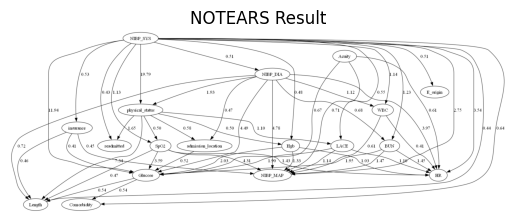

In [20]:
G = nx.DiGraph()
for i in range(len(columns)):
    for j in range(len(columns)):
        weight = W[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns[j],
                columns[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/notears1_age2.png")

img = plt.imread("figures/notears1_age2.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

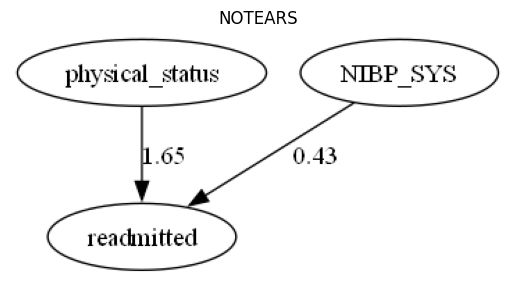

In [21]:
X = group2_sel.to_numpy().astype(np.float32)
columns = group2_sel.columns.tolist()

target_node = "readmitted"

G = nx.DiGraph()
target_idx = columns.index(target_node)

for i in range(len(columns)):
    weight_in = W[target_idx, i]
    if i != target_idx and abs(weight_in) > 0.01:
        G.add_edge(columns[i], target_node, weight=weight_in, label=f"{weight_in:.2f}")
        
    weight_out = W[i, target_idx]
    if i != target_idx and abs(weight_out) > 0.01:
        G.add_edge(target_node, columns[i], weight=weight_out, label=f"{weight_out:.2f}")

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/notears1_age2_only.png")

img = plt.imread("figures/notears1_age2_only.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS")
plt.show()

10 variables

In [26]:
features2 = [
    "physical_status", "Length", "LACE", "Comorbidity", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "readmitted"
]
group1_sel = group1[features2]
group2_sel = group2[features2]
group3_sel = group3[features2]

X2 = group3_sel.to_numpy().astype(np.float32)
columns2 = group3_sel.columns.tolist()

d2 = X2.shape[1]
model2 = NotearsMLP(dims=[d2, 10, 1], bias=True)

W2 = notears_nonlinear(
    model2,           
    X2,               
    lambda1=0.1,    # L1 regularization for sparsity; higher values yield fewer edges
    lambda2=0.05,    # L2 regularization for smoothness; helps prevent overfitting
    max_iter=100,    
    h_tol=1e-6,      # Tolerance for DAG constraint convergence; lower is stricter
    rho_max=1e+16,   # Maximum penalty parameter for augmented Lagrangian
    w_threshold=0.5
    )

d:\Anaconda\envs\causalnex\lib\site-packages\scipy\linalg\_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


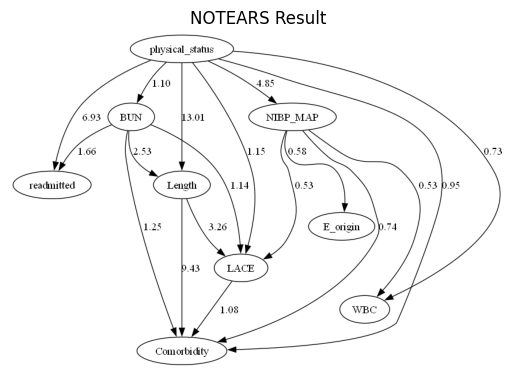

In [27]:
G = nx.DiGraph()
for i in range(len(columns2)):
    for j in range(len(columns2)):
        weight = W2[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns2[j],
                columns2[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/notears2_age3.png")

img = plt.imread("figures/notears2_age3.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

6 variables

In [36]:
features3 = [
    "physical_status", "Length", "LACE", "Comorbidity", "readmitted"
]

group1_sel = group1[features3]
group2_sel = group2[features3]
group3_sel = group3[features3]

X3 = group3_sel.to_numpy().astype(np.float32)
columns3 = group3_sel.columns.tolist()

d3 = X3.shape[1]
model3 = NotearsMLP(dims=[d3, 10, 1], bias=True)

W3 = notears_nonlinear(
    model3,           
    X3,               
    lambda1=0.1,   
    lambda2=0.1,    
    max_iter=100,    
    h_tol=1e-7,      
    rho_max=1e+16,   
    w_threshold=0.2
    )

d:\Anaconda\envs\causalnex\lib\site-packages\scipy\linalg\_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


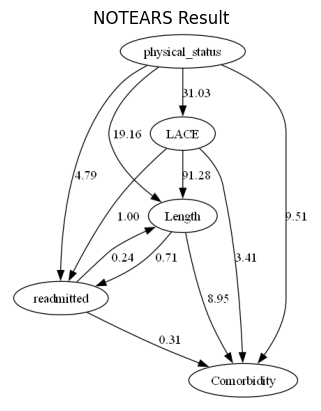

In [37]:
G = nx.DiGraph()
for i in range(len(columns3)):
    for j in range(len(columns3)):
        weight = W3[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns3[j],
                columns3[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/notears3_age3.png")

img = plt.imread("figures/notears3_age3.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

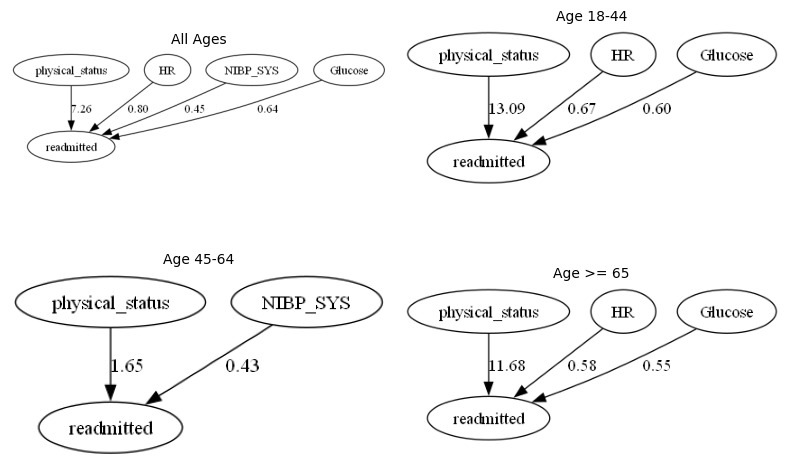

In [40]:
image_paths = [
    "figures/notears_readmitted_only2.png",
    "figures/notears1_age1_only.png",
    "figures/notears1_age2_only.png",
    "figures/notears1_age3_only.png"
]

titles = ["All Ages", "Age 18-44", "Age 45-64", "Age >= 65"]

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for i, ax in enumerate(axs.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

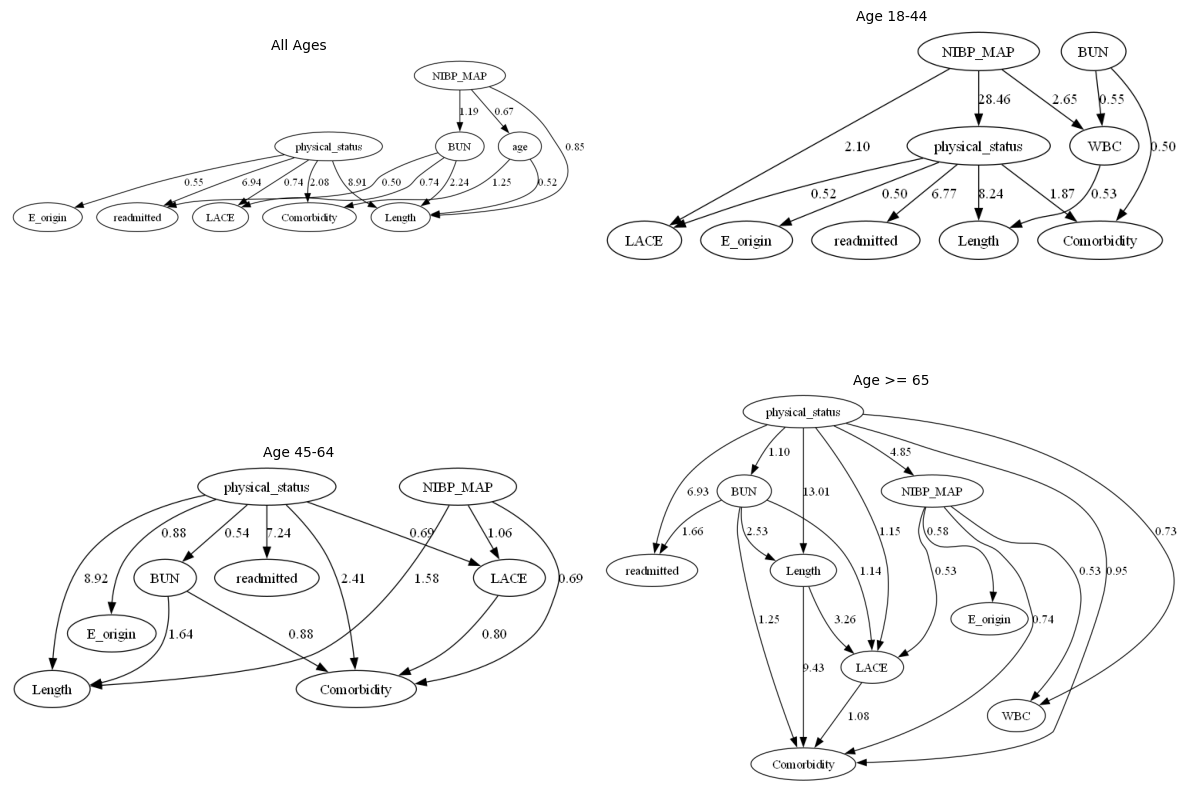

In [42]:
image_paths = [
    "figures/nonlinear_notears3.png",
    "figures/notears2_age1.png",
    "figures/notears2_age2.png",
    "figures/notears2_age3.png"
]

titles = ["All Ages", "Age 18-44", "Age 45-64", "Age >= 65"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

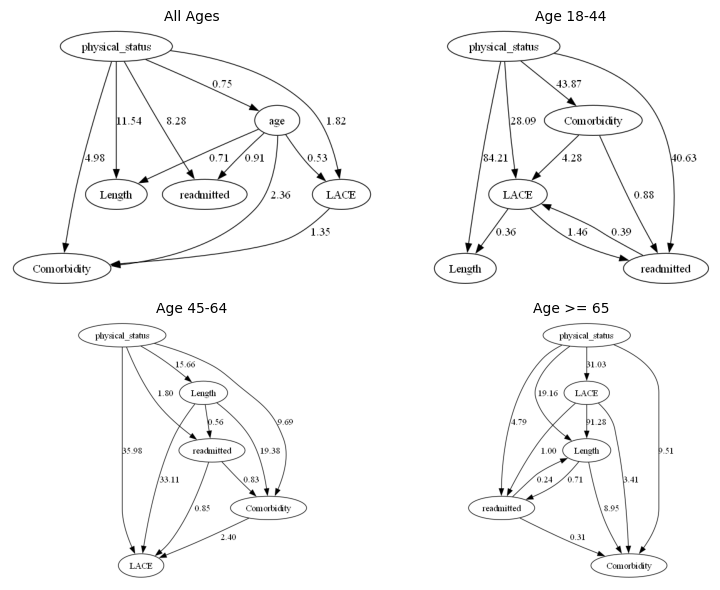

In [47]:
image_paths = [
    "figures/nonlinear_notears4.png",
    "figures/notears3_age1.png",
    "figures/notears3_age2.png",
    "figures/notears3_age3.png"
]

titles = ["All Ages", "Age 18-44", "Age 45-64", "Age >= 65"]

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for i, ax in enumerate(axs.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()